# Predicting Classical Composers from Spectrograms

Let's try to accurately predict composers from spectrograms of their compositions. We're going to strip away everything about a composition other than its frequency distribution through time if the composition were played by a single instrument (organ).

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [4]:
from fastai import *
from fastai.vision import *

## Data
I found a great data set on a subreddit for DJs who use MIDI files to sample classical music.

It included 370,000 MIDI files, which I filtered down to classical compositions.

Unfortunately, the data is a mess. Some folders are composers, some are compositions, and there's no clear order to any of the files.

![messy data](./img/normalization_1.png)

We need to get things in a roughly sensible order. I manually dumped compositions to the folder of their composer as best I could. Then I merged duplicate folders, and extracted any zipped midi files. This gives us a list of folders named by composer.

Let's normalize our folders and files.

### Normalization
Since we'll use folder names as our labels, let's normalize our folder names first. This sets all the composer names we made in the last step to lowercase.

```py
from pathlib import Path
from sys import argv

# Downcases the names of all directories inside the current directory.

path = Path('.')
dirs = [file for file in path.iterdir() if file.is_dir()]
for (x, dir) in enumerate(dirs):
    print('Changing', dir)
    dir.rename(dir.name.lower())
print('Done')
```

Next, let's normalize our file names to get them ready for conversion.

```py
#!/usr/bin/env python3

from pathlib import Path
from sys import argv

# Recursive Renaming!
# Converts all files in specified directory to format [foldername]_[filenumber]
def rename_files(folder_path, folder_name):
    files = [file for file in folder_path.iterdir() if file.is_file() and ("mid" in file.name)]
    for (x, file) in enumerate(files):
        print('Renaming', file)
        file.rename(f'{folder_path}/{folder_name}_{x}.mid')
    print('Done')

def recursive_rename(dir_path):
    folders = [folder for folder in dir_path.iterdir() if folder.is_dir()]
    for folder in folders:
        print('Renaming:', folder.name)
        rename_files(root_path/f'{folder.name}', folder.name)

if (len(argv) < 2):
    raise Exception('Please specify a path')
path = Path(argv[1])
recursive_rename(root_path)
```

### MIDI to WAV
Next we need to convert our MIDI files to WAV files, so we can process them into a spectrogram.

MIDI files not only encode the notes of a given composition, but also data about the instruments. Our source data has symphonies, pieces for solo guitar, piano concertos, and just about everything in between. Some composers wrote heavily for certain instrument groups, so we *could* use this instrumentation data to predict.

But for this project we'll see if we can find patterns in only the notes themselves. To do this, we need to convert all MIDIs to the same synth. All compositions will use the same organ-like synth sound.

We'll use a [NodeJS package called synth](https://github.com/patrickroberts/synth-js) to handle the conversion.

Here are two scripts that convert all midi files in a directory. The bash and python scripts should be in the same directory. You can call it like this: ```./convert_all_midi_files_script.py ./my-compositions-directory-here```

```py
#!/usr/bin/env python3

from pathlib import Path
from sys import argv
import subprocess
import shlex

# Takes in a directory and converts all midi files to .wav

def convert_all_midi_to_wav(folder_path):
    files = [file for file in folder_path.iterdir() if file.is_file() and ("mid" in file.name)]
    for (x, file) in enumerate(files):
        without_file_extension = file.name[:-4]
        resolved = Path(f'{folder_path}/{without_file_extension}')
        # synth adds .mid to input file by default, so we remove it first
        if (Path(f'{resolved}.wav').is_file() == False):
            # Check if .wav exists, so we can safely re-run the file without re-converting
            # any files that were already converted
            print('Converting...', without_file_extension)
            subprocess.call(shlex.split(f'./convert_midi_to_wav.sh {resolved}'))


def do_recursively_on_folders(dir_path, action):
    folders = [folder for folder in dir_path.iterdir() if folder.is_dir()]
    for folder in folders:
        action(folder)

path = Path(argv[1])
do_recursively_on_folders(path, convert_all_midi_to_wav)

```

Here's the companion bash script.

```sh
#!/usr/bin/env bash

synth -i $1
```

Conversion may take a long time! Don't worry if something fails or the script gets interrupted. You can call the script as many times as you need without worrying about overwriting or losing the files you've already converted.

![converting to .wav files](./img/conversion.gif)

### WAV to Spectrogram

With our data organized by composer and converted to WAV files, it's time to make our spectrograms!

A [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) is a visual representation of sound and its properties. 

Our spectrograms will plot frequency on the y axis and time on the x axis. The intensity of colors suggests a higher density of a given frequency at a point in time.

Here's another script to convert all our WAV files to spectrograms. This will take a while!

```py
#!/usr/bin/env python3

from pathlib import Path
from sys import argv
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

def create_spectrograms(folder_path):
    files = [file for file in folder_path.iterdir() if file.is_file() and ("wav" in file.name)]
    for (x, file) in enumerate(files):
        without_file_extension = file.name[:-4]
        resolved = Path(f'{folder_path}/{without_file_extension}')
        if (Path(f'{resolved}.png').is_file() == False):
            print('making spectro for', resolved)
            sample_rate, samples = wavfile.read(file)
            frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
            plt.pcolormesh(np.log(spectrogram))
            plt.axis('off')
            plt.ylim(ymax=40)
            # plt.show() # Uncomment if you want to check out the plot.
            plt.savefig(f'{resolved}.png', transparent=True)
            # saves the file as a .png with transparent background (no border)

def do_recursively_on_folders(dir_path, action):
    folders = [folder for folder in dir_path.iterdir() if folder.is_dir()]
    for folder in folders:
        action(folder)

if (len(argv) < 2):
    raise Exception('Please specify a path')
path = Path(argv[1])
do_recursively_on_folders(path, create_spectrograms)
```

Converting...
![spectrogram conversion](./img/spectro-conversion.gif)

Look at these beautiful spectrograms!

Here's a Mozart, which looks pretty orderly and [Classical](https://en.wikipedia.org/wiki/Classical_period_(music)).
![mozart spectrogram](./img/mozart_sample.png)

Here's a Beethoven, looking a bit more [Romantic](https://en.wikipedia.org/wiki/Romantic_music).
![beethoven spectrogram](./img/beethoven_sample.png)

And here's early-20th century composer [Charles Griffes](https://en.wikipedia.org/wiki/Charles_Tomlinson_Griffes), looking wild and [Modern](https://en.wikipedia.org/wiki/Modernism_(music)).
![charles griffes spectrogram](./img/griffes_sample.png)

Finally, here's [Arnold Schoenberg](https://en.wikipedia.org/wiki/Arnold_Schoenberg) with one of his atonal masterpieces. The gaps in the image suggest some data corruption in the .wav.

![schoenberg spectrogram](./img/schoenberg_sample.png)

### Moving Data to GCP
We need to get our data to our GPU-enabled computer. I'm using a compute instance on [GCP](https://cloud.google.com) to train our model. This step assumes you're using GCP too. If you're not, just ignore this step!

Let's zip up all our files to make them smaller and easier to send.

```sh
# Recursively zips our 'data' directory into a tarball named 'composition.tar.gz', excluding the wav and mid files we made in previous steps.
tar -czvf compositions.tar.gz --exclude=*.wav --exclude=*.mid --exclude=*DS_Store ./data

```
Cool. The easiest way to get our data to GCP is with [scp](https://www.garron.me/en/articles/scp.html).

Yep, you guessed it, here's another script to send your files off to Google Cloud.

```sh
#! /bin/bash
gcloud compute scp path-to-your-tar.tar.gz your-gcp-instance-here:~
```

You may need to move the files from your root directory in GCP to another location depending on how your files are organized.

Untar your data with: 

```sh
#! /bin/bash
tar -zxvf yourfile.tar.gz
```

## Training
Sweet. We're ready to load our data into a model and start training!

We'll start with [Resnet 34](https://www.kaggle.com/pytorch/resnet34), a model pre-trained for image recognition.

Let's load in our data!

In [3]:
path = Path('compositions')

We'll use fastai's DataBunch class to get validation and training sets from our data. We'll train on 70% of the data and validate on 30%.


In [10]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=224)

`.from_folder` automatically looks through a directory of folders sorted by class and splits the files contained in each class into a `train` (training) and `valid` (validation) set.

ImageDataBunch takes a few additional parameters to help prepare our data for our model. `get_transforms()` creates a list of transforms that we'll apply to our images using the ds_tfms parameter. These include transforms like cropping and zooming the images.

We'll also set size to 224 since this 224x224 are the dimensions of the images used to train Resnet34.

### Sanity Check!
Before we continue let's sanity check our data.

First, let's peek a few rows to make sure they look right:

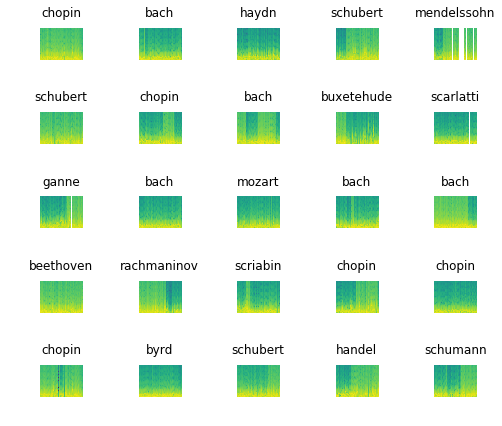

In [11]:
data.show_batch(rows=5, figsize=(7,6))

Looking good. Let's make sure our class labels look alright:

In [12]:
print(data.classes)
len(data.classes),data.c

['albéniz', 'alkan', 'ambroise', 'arensky', 'arndt', 'bacewitz', 'bach', 'balakirew', 'barber', 'bartelet', 'bartok', 'becker', 'beethoven', 'bellini', 'berlin', 'bernstein', 'bizet', 'bloch', 'boccherini', 'borodin', 'botsford', 'brahms', 'bruch', 'burgmuller', 'busoni', 'busser', 'buxetehude', 'byrd', 'chabrier', 'chaminade', 'chasins', 'chopin', 'clarke', 'clementi', 'coates', 'coleridge-taylor', 'cons', 'copland', 'couperin', 'cramer', 'czerny', 'czibulka', 'debussy', 'diabelli', 'durand-e', 'durand-m-a', 'dussek', 'dvorak', 'elgar', 'ewazen', 'faure', 'field', 'finck', 'flotow', 'franck', 'friedman', 'fucick', 'ganne', 'german', 'gershwin', 'ginastera', 'godowsky', 'gottschalk', 'grainger', 'granados', 'grieg', 'griffes', 'handel', 'haydn', 'heidrich', 'heller', 'hemery', 'herold', 'hiller', 'holst', 'holst-m', 'hummel', 'ivanovici', 'jakobowski', 'jensen', 'joplin', 'komzak', 'kuhlau', 'lange', 'laurent', 'lavallee', 'leclair', 'lecuona', 'lemire', 'liszt', 'lyssenko', 'macbeth'

(149, 149)

Cool! Let's go ahead and create our learner and train it with 5 cycles through the data.

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5)

Total time: 01:40
epoch  train_loss  valid_loss  error_rate
1      4.501088    5.522526    0.958442    (00:20)
2      2.834725    2.738575    0.605195    (00:20)
3      1.868241    1.348855    0.244156    (00:19)
4      1.278756    1.271678    0.207792    (00:20)
5      0.926392    1.247358    0.212987    (00:20)



Let's save the model so we can use it in future sessions without having to wait for training again.

In [15]:
learn.save('res-34')

Cool. Our model is looking not too bad, with a roughly 79% accuracy rate. This is a decent first start.

Let's try a few more epochs and see how we're doing.

In [22]:
learn.load('res-34')

In [23]:
learn.fit_one_cycle(3)

Total time: 01:00
epoch  train_loss  valid_loss  error_rate
1      0.479490    1.316542    0.231169    (00:20)
2      0.439877    1.270896    0.225974    (00:20)
3      0.334336    1.198452    0.189610    (00:20)



With our accuracy up to about 81%, we're doing pretty well. For a deep learning model 81% is not outstanding. But if we consider that we're identifying the composer of classical music by *looking at spectrograms*, this is pretty cool. I'd be pretty impressed if someone could hear a piece and correctly identify the composer 81% of the time!

In [40]:
learn.save('resnet-34-8-epoch')

## Model Interpretation and Analysis

Let's look more deeply at how we're doing. Specifically, we want to understand where our model is confused.

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

First we'll plot our `top_losses`. These are the images that the model was most confused about. fastai offers the  `ClassificationInterpretation` class to help us understand our model

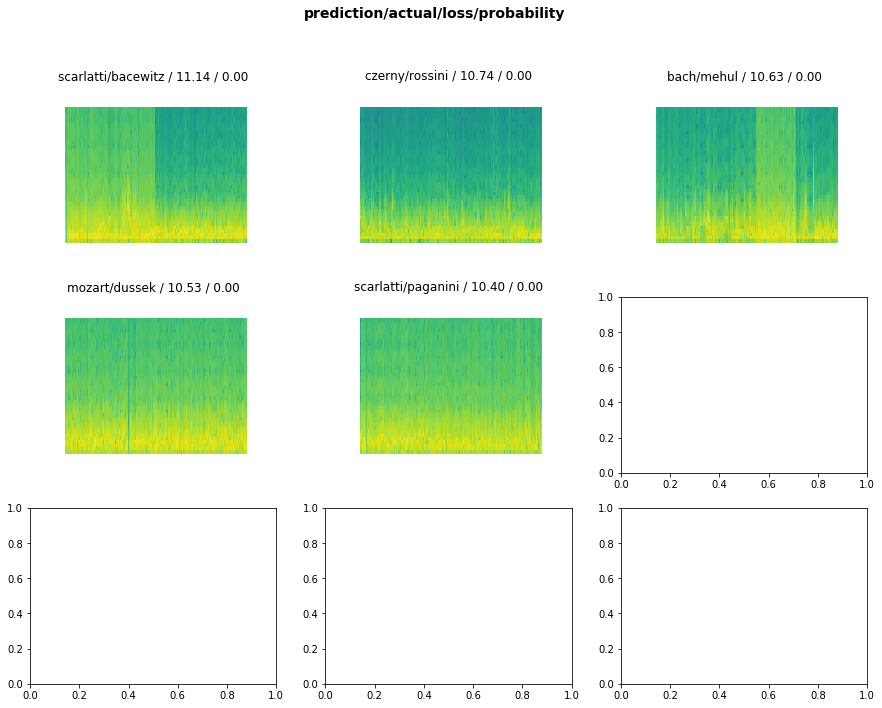

In [45]:
interp.plot_top_losses(5, figsize=(15,11))

Based on the spectrograms, it's a bit hard to say whether these confusions are reasonable or not. Let's compare the confusion based on musical era.

Here are our composers and their lifespans:

- Scarlatti (1685-1757)
- Bacewitz (1909-1969)
- Czerny (1791-1857)
- Rossini (1792-1868)
- Bach (1685-1750)
- Méhul (1763-1817)
- Mozart (1756-1791)
- Dussek (1760-1812)
- Paganini (1782-1840)

Scarlatti/Bacewitz: This is definitely a big confusion.
Czerny/Rossini: These composers were contemporaries, born one year apart. Not unreasonable.
Bach/Mehul: These composers were not contemporaries. Méhul is often considered an early Romantic and Bach was squarely in the Baroque period. Seems like confusion.
Mozart/Dussek: Contemporaries in a similar style. Like Mozart's, Dussek's later pieces are considered precursors to Romanticism. Not unreasonable.
Scarlatti/Paganini: Confusion.

Of our top losses, we have 3/5 which are obviously confusions.

Next, we'll plot a confusion matrix. A confusion matrix visualizes the labels that the model is most confused about. If you look to the above and below the sharp diagonal line, you'll see how many times a pair of labels was miscategorized. You may have to zoom in to see the matrix clearly!

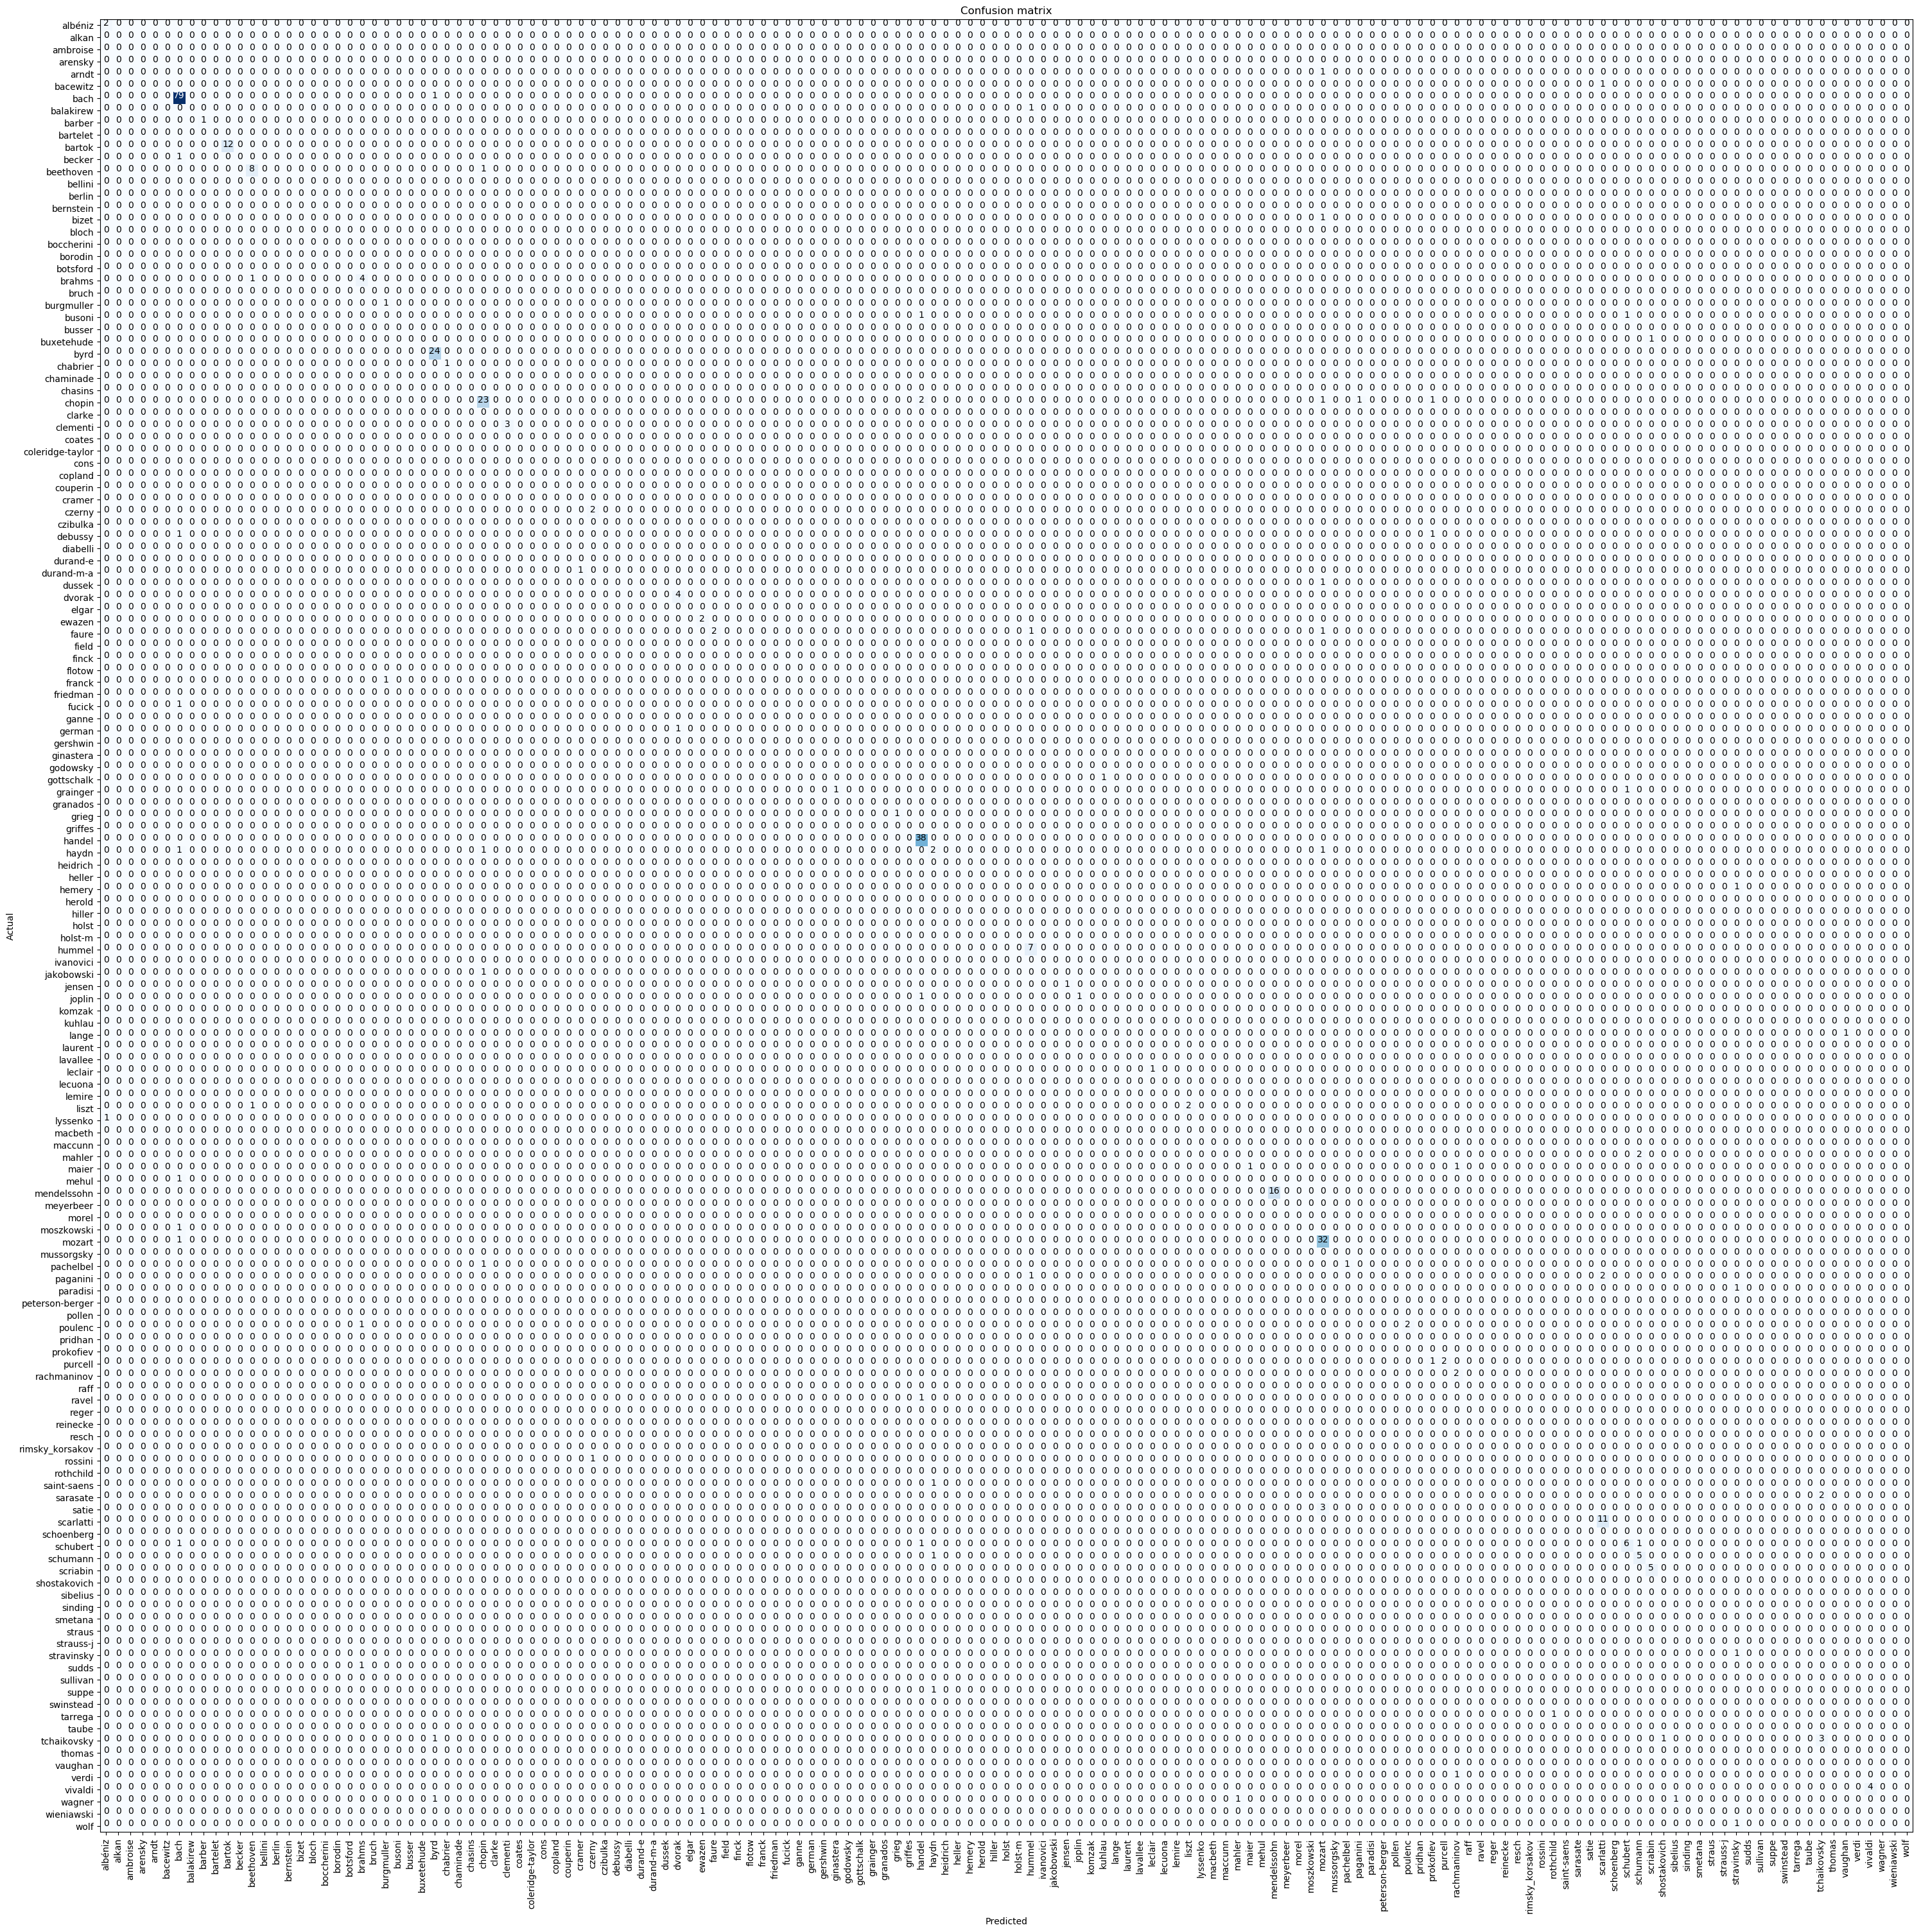

In [46]:
interp.plot_confusion_matrix(figsize=(30,30), dpi=100)

As we look across the diagonal line that indicates correct identification by our model, a pattern starts to emerge. The highest performers were overwhelmingly the classes with the most data. Famous composers like Bach, Mozart, Mendolssohn and Scarlatti, which were well-represented in our data set, are well classified. We correctly identified Bach 79 times, Chopin 23 times, and Bartok 12 times!

This tells us that we might be able to improve our model just by getting a lot more spectrograms, especially for the less famous composers in our list. We should also take our accuracy estimates with a grain of salt. If we removed our best represented composers from our dataset, our accuracy would plummet.

Let's check out our most confused pairs to see what else we can learn.

In [48]:
interp.most_confused(min_val=2)

[('satie', 'mozart', 3)]

This *seems* great! Is our model only majorly confused between Satie and Mozart?

But wait! Let's lower our min_val.

In [54]:
interp.most_confused(min_val=0)

[('satie', 'mozart', 3),
 ('chopin', 'handel', 2),
 ('mahler', 'schumann', 2),
 ('paganini', 'scarlatti', 2),
 ('sarasate', 'tchaikovsky', 2),
 ('arndt', 'mozart', 1),
 ('bacewitz', 'scarlatti', 1),
 ('bach', 'byrd', 1),
 ('balakirew', 'hummel', 1),
 ('becker', 'bach', 1),
 ('beethoven', 'chopin', 1),
 ('bizet', 'mozart', 1),
 ('brahms', 'beethoven', 1),
 ('busoni', 'handel', 1),
 ('busoni', 'schubert', 1),
 ('buxetehude', 'scriabin', 1),
 ('chopin', 'mozart', 1),
 ('chopin', 'paganini', 1),
 ('chopin', 'prokofiev', 1),
 ('debussy', 'bach', 1),
 ('debussy', 'prokofiev', 1),
 ('durand-m-a', 'cramer', 1),
 ('dussek', 'mozart', 1),
 ('faure', 'hummel', 1),
 ('faure', 'mozart', 1),
 ('franck', 'burgmuller', 1),
 ('fucick', 'bach', 1),
 ('german', 'dvorak', 1),
 ('gottschalk', 'kuhlau', 1),
 ('grainger', 'ginastera', 1),
 ('grainger', 'schubert', 1),
 ('haydn', 'bach', 1),
 ('haydn', 'chopin', 1),
 ('haydn', 'mozart', 1),
 ('hemery', 'stravinsky', 1),
 ('jakobowski', 'chopin', 1),
 ('joplin

Yikes. 

For a classifier with fewer labels (a dataset with fewer composers), we could set a higher minimum value. We would only be interested in seeing where our model consistently confuses two labels.

But since we have so many labels, our model might be confused about a particular composer but not confused about that composer in relation to only one other class.

As you can see in our list, Schubert is confused three times, but not more than once with any other composer. Here we can see that the model does struggle with certain composers like Schubert.

### Improving the Model with Resnet 50
Let's take another pass at this problem using Resnet 50, a larger and deeper pre-trained model for image classification.

We'll follow the same process as last time, just with slightly different parameters. Since Resnet 50 is more memory intensive, we'll need to lower our batch size (bs) to 16.

In [4]:
data = data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=224, bs=16)
data.normalize()

In [14]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [15]:
learn.fit_one_cycle(5)

Total time: 03:07
epoch  train_loss  valid_loss  error_rate
1      2.744834    1.621146    0.334197    (00:37)
2      1.525998    1.382335    0.266839    (00:37)
3      1.080742    1.132412    0.230570    (00:37)
4      0.619873    1.063505    0.183938    (00:37)
5      0.358404    1.027823    0.181347    (00:37)



In [16]:
learn.save('res-50')

In [ ]:
lean.load('res-50')

Awesome! We're at roughly 82% accuracy. That's already better than our resnet-30 model, but after only 5 epochs. It looks like we may be overfitting our data here, but let's keep going.

Let's see if we can't tune it up a bit more by unfreezing our model and letting every layer get trained equally.

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(1)

Total time: 00:51
epoch  train_loss  valid_loss  error_rate
1      2.395203    2.774431    0.512953    (00:51)



Whoa! Bad idea. Let's go back to our original model and tune it try unfreezing again, but with a better learning rate.

In [32]:
learn.load('res-50')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


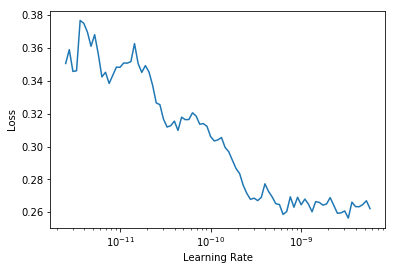

In [27]:
learn.lr_find(start_lr=1e-12, end_lr=1e-8)
learn.recorder.plot()

We can pick a slice with a nice downward trend to set our learning rate. From about 10^-11 to 10^-9 should do.

In [33]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-11,1e-10))

Total time: 00:49
epoch  train_loss  valid_loss  error_rate
1      0.249244    1.021482    0.178756    (00:49)



Awesome! Although we're still not near 100% accuracy, this model works pretty well given our limited data.

We learned a basic but useful workflow for creating deep learning models using [fastai](https://github.com/fastai/fastai). Most importantly, we figured out that it's *possible* to detect composers from spectrograms. But there's still a lot of problems with this model.

First, our model falls flat with composers that aren't well represented in the data. Our accuracy would significantly decrease if removed even one composer (Bach) from our dataset.

Second, we're using a model pre-trained on ImageNet. ImageNet was trained on real objects like dogs and cars. Since we're using spectrograms, we likely only benefit from the earliest layers in our pre-trained model. These early layers detect more abstract shapes like lines and corners, which exist in spectrograms just as they exist on the pre-trained data. But later layers, which detect features like eyes or signs, probably don't help our model much. Perhaps we could unfreeze the entire model and train it from scratch, letting the features of spectrograms emerge over time. Or we could search for a model pre-trained on spectrograms.

We definitely should add more data by finding more MIDI files or transforming our images. We could also try this same approach with better spectrograms, like those generated by [Librosa](https://github.com/librosa/librosa).

Thanks for reading!

[Github](https://github.com/zcaceres)
[Twitter](https://twitter.com/zachcaceres)
[Website](http://zachcaceres.com)